# Logical Error Rate Evaluation (rotated surface code)

In [22]:
# This cell is tagged `parameters` and will be override by `papermill`
decoder = "mwpm"
json_filename = "mwpm.json"  # where to save the result, must be provided

slurm_maximum_jobs = 100
local_maximum_jobs = 10

In [4]:
from qec_lego_bench.hpc.monte_carlo import MonteCarloJob, LogicalErrorResult, MonteCarloJobExecutor
from qec_lego_bench.hpc.submitter.min_shots_submitter import MinShotsSubmitter
from qec_lego_bench.hpc.submitter.precision_submitter import PrecisionSubmitter
from qec_lego_bench.hpc.plotter.job_progress_plotter import JobProgressPlotter
from qec_lego_bench.hpc.plotter.logical_error_rate_plotter import LogicalErrorRatePlotter
from typing import Iterable
from qec_lego_bench.cli.logical_error_rate import logical_error_rate

### Define the job list

In [36]:
d_vec = [3, 5, 7, 9, 11]
p_vec = [0.03 * 0.1 ** (i / 8) for i in range(1, 24)]

# d_vec = [3]
# p_vec = [0.01, 0.03]

jobs = [MonteCarloJob(d=d, p=p) for d in d_vec for p in p_vec]


def monte_carlo_function(shots: int, d: int, p: float) -> tuple[int, LogicalErrorResult]:
    stats = logical_error_rate(decoder=decoder, code=f"rsc(d={d},p={p})", max_shots=shots, max_errors=shots, no_progress=True, no_print=True)
    return stats.shots, LogicalErrorResult(errors=stats.errors, discards=stats.discards)

monte_carlo_function(1000, min(d_vec), max(p_vec))

(1000, LogicalErrorResult(errors=191, discards=0))

### Define the strategy to submit jobs

In [6]:
min_shots_submitter = MinShotsSubmitter(shots=10000)
precision_submitter = PrecisionSubmitter(time_limit=10*3600, min_precision=1)
more_precision_submitter = PrecisionSubmitter(time_limit=50*3600, min_precision=2)
def submitter(jobs: Iterable[MonteCarloJob]) -> list[tuple[MonteCarloJob, int]]:
    submit = min_shots_submitter(jobs)
    submit += precision_submitter(jobs)
    if len(submit) == 0 and all([job.pending_shots == 0 for job in jobs]):  # previous submitter all finished
        submit += more_precision_submitter(jobs)
    return submit

### Define the callback, e.g. plotting the intermediate result and the list of remaining tasks

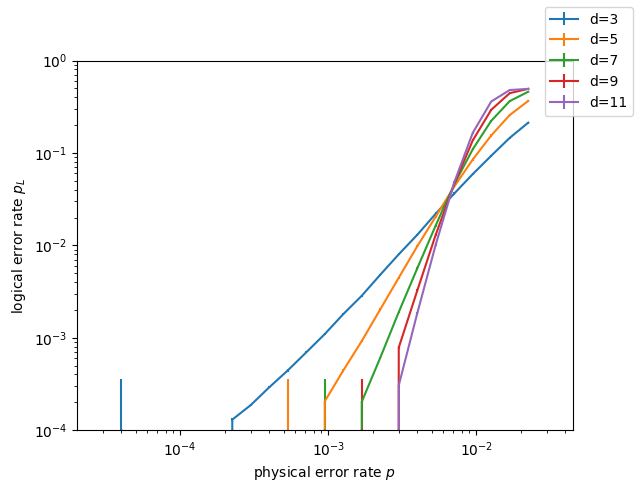

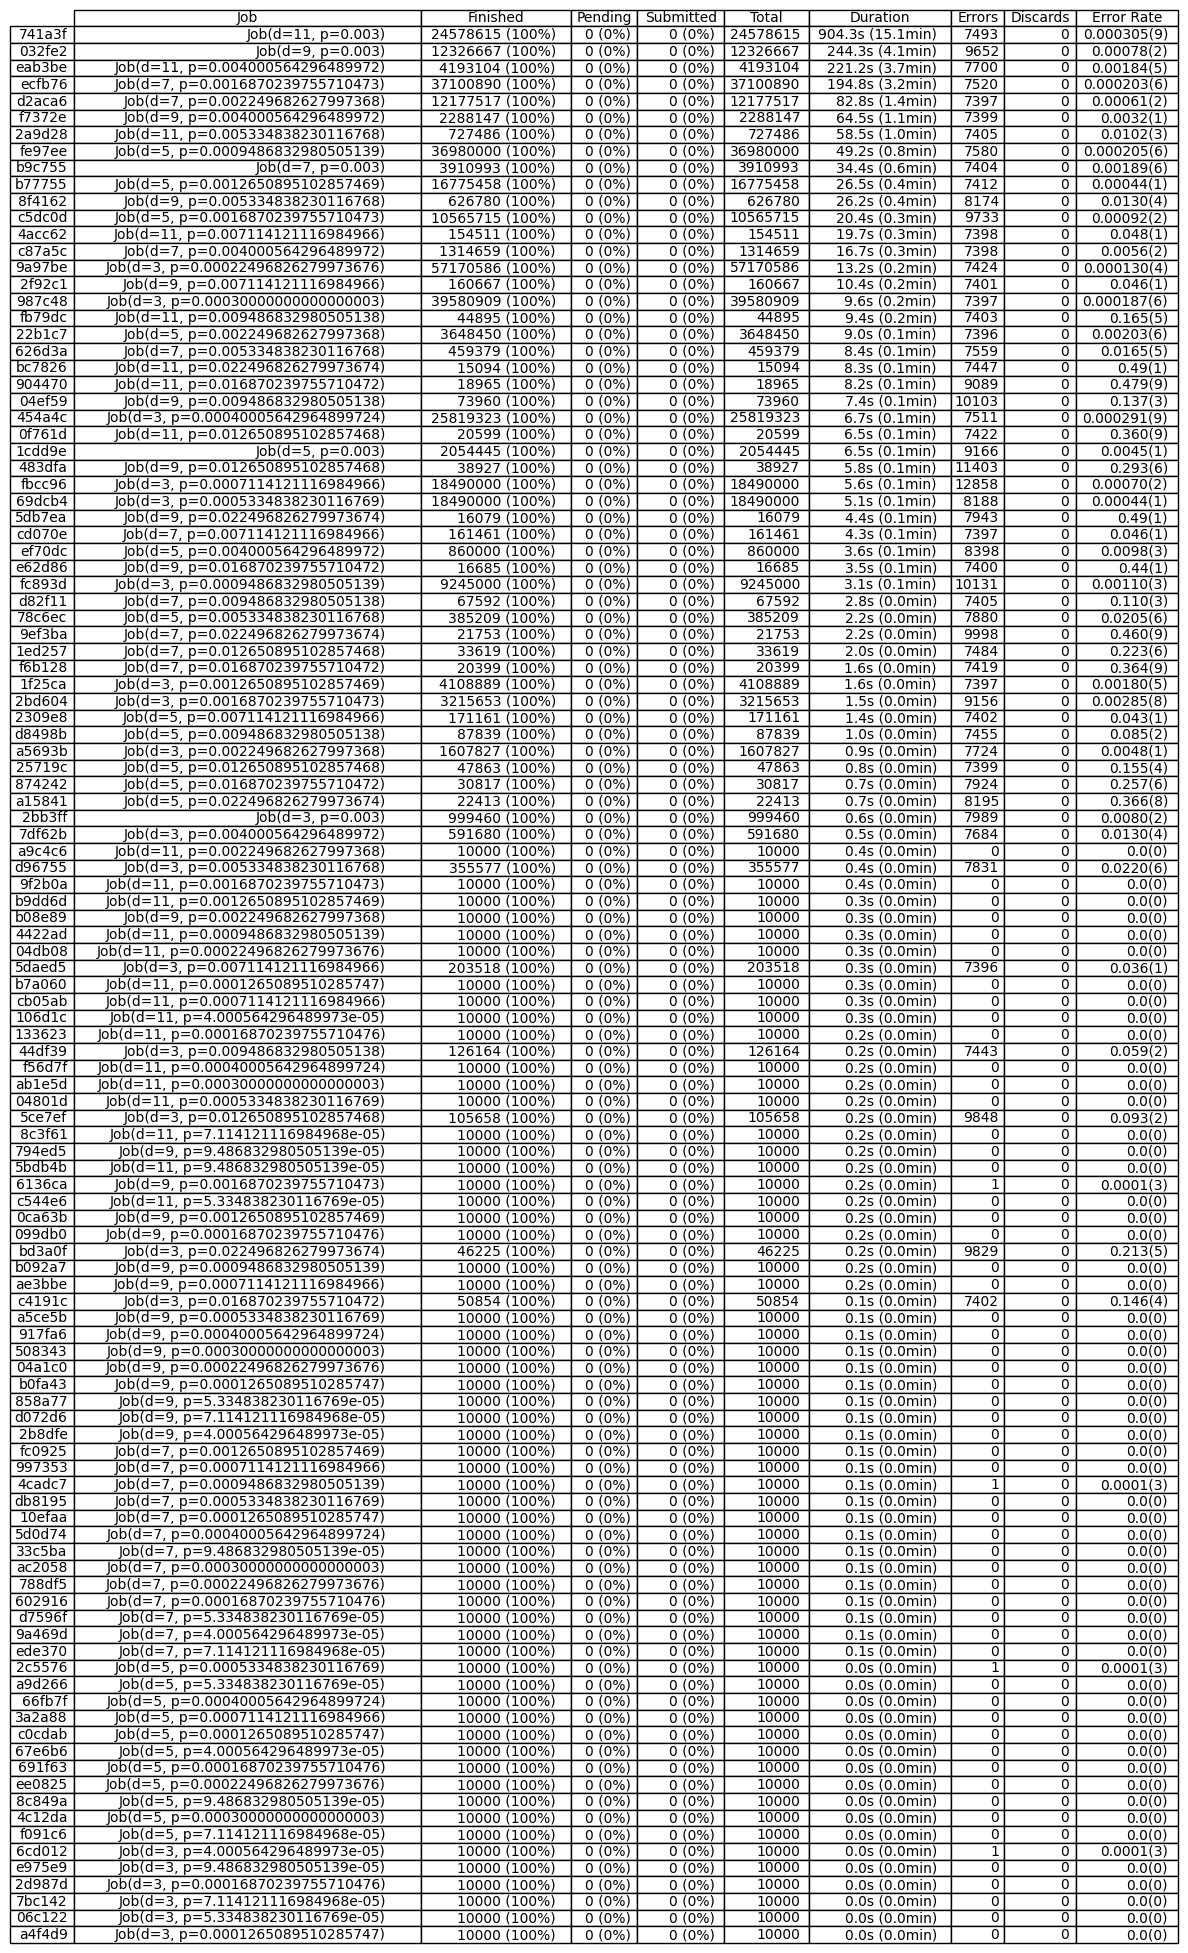

In [7]:
plotter = LogicalErrorRatePlotter(d_vec, p_vec)
progress_plotter = JobProgressPlotter()
def callback(executor: MonteCarloJobExecutor):
    plotter(executor)
    progress_plotter(executor)

# The rest of the notebook runs the evaluation

Start a cluster by intelligently choose Slurm or Local cluster.

In [33]:
try:
    from dask_jobqueue import SLURMCluster
    from dask.distributed import Client
    cores_per_node = 10
    n_workers = slurm_maximum_jobs // cores_per_node
    assert n_workers < 200, "Yale HPC forbids submitting more than 200 jobs per hour"
    cluster = SLURMCluster(
        queue='scavenge',
        cores=cores_per_node,
        processes=cores_per_node,
        memory=f"{4 * cores_per_node} GB",
        walltime="6:00:00",  # 6 hours
    )
    print(cluster.job_script())
    cluster.scale(slurm_maximum_jobs)
except Exception as e:
    print(e)
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster(n_workers=local_maximum_jobs)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenge
#SBATCH -n 1
#SBATCH --cpus-per-task=10
#SBATCH --mem=38G
#SBATCH -t 6:00:00

/home/yw729/.conda/envs/qec/bin/python -m distributed.cli.dask_worker tcp://10.181.166.45:37217 --name dummy-name --nthreads 1 --memory-limit 3.73GiB --nworkers 10 --nanny --death-timeout 60



/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45851 instead
  warnings.warn(


In [40]:
cluster

Dashboard: http://10.181.166.45:45851/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.181.166.45:37217,Workers: 0
Dashboard: http://10.181.166.45:45851/status,Total threads: 0
Started: 12 minutes ago,Total memory: 0 B


In [41]:
shudown_cluster = True

if shudown_cluster:
    print("will shut down the cluster after job finishes; if this is not desired, set `shudown_cluster` to False")
with Client(cluster) as client:
    try:
        executor = MonteCarloJobExecutor(
            client,
            monte_carlo_function,
            jobs,
            filename=json_filename,
        )
        executor.execute(submitter, loop_callback=callback)
    finally:
        if shudown_cluster:
            print("shutting down the whole cluster; if this is not desired, set `shudown_cluster` to False")
            client.shutdown()

will shut down the cluster after job finishes; if this is not desired, set `shudown_cluster` to False


RuntimeError: Trying to connect to an already closed or closing Cluster SLURMCluster(eeb01db7, 'tcp://10.181.166.45:37217', workers=0, threads=0, memory=0 B).